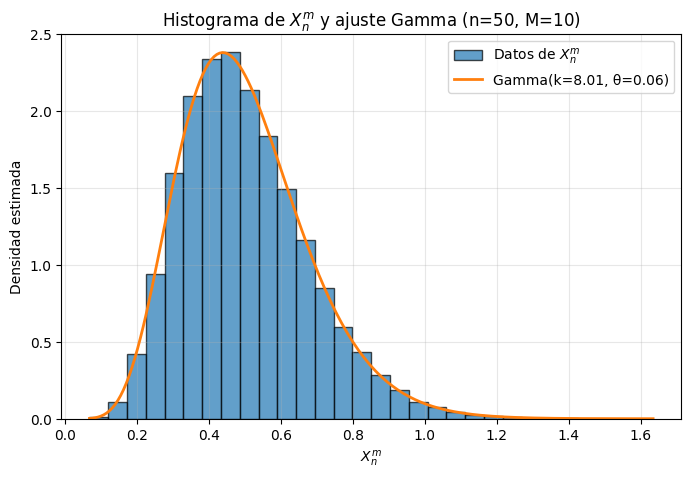

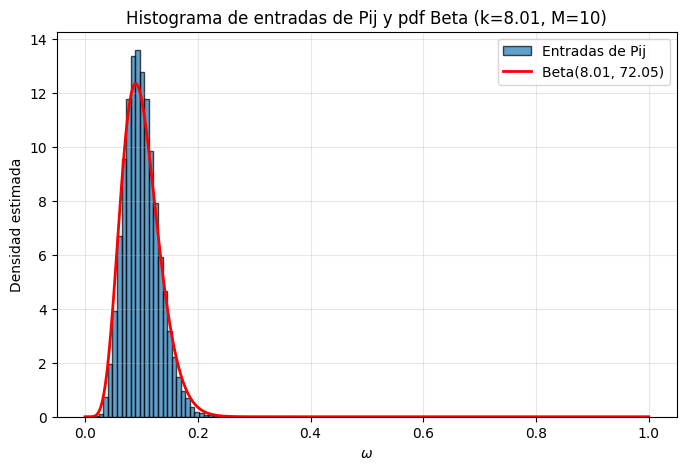

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, beta  # para la densidad de la gamma y beta

def simulate_XnM_and_P(n, M, num_sims=10000, num_bins=50, sigma=1.0):
    """
    Simula valores de X_n^m para m = 1..M con n iteraciones,
    calcula la matriz P acumulada y representa:
      1) Histograma de X_n^m con ajuste Gamma.
      2) Histograma de entradas de Pij con superposición de Beta.
    """
    results_X = np.zeros((num_sims, M))
    all_P_entries = []

    for sim in range(num_sims):
        X0 = np.random.rand(M)
        P = np.eye(M)
        for _ in range(n):
            # Generar W exponencial (o uniforme)
            scale = 1.0
            W = np.random.exponential(scale=scale, size=(M, M))
            #W = np.random.rand(M,M)
            # Normalizar filas de W
            row_sums = W.sum(axis=0, keepdims=True)
            row_sums_safe = np.where(row_sums == 0, 1, row_sums)
            W = W / row_sums_safe
            P = W @ P

        Xn = P @ X0
        results_X[sim, :] = Xn
        all_P_entries.append(P.flatten())

    flattened_X = results_X.flatten()
    flattened_X = flattened_X[(flattened_X >= 0) & (flattened_X <= 700)]
    all_P_entries = np.concatenate(all_P_entries)
    all_P_entries = all_P_entries[(all_P_entries >= 0) & (all_P_entries <= 1)]

    # Ajuste Gamma para X_n^m
    mean_X = np.mean(flattened_X)
    var_X  = np.var(flattened_X, ddof=1)
    k_X     = mean_X**2 / var_X
    theta_X = var_X / mean_X

    # Histograma de X_n^m con Gamma
    plt.figure(figsize=(8, 5))
    counts_X, bins_X, _ = plt.hist(
        flattened_X, bins=num_bins, density=True,
        edgecolor='black', alpha=0.7, label=r'Datos de $X_n^m$'
    )
    x_pdf = np.linspace(bins_X[0], bins_X[-1], 200)
    y_pdf = gamma.pdf(x_pdf, a=k_X, scale=theta_X)
    plt.plot(x_pdf, y_pdf, lw=2,
             label=f'Gamma(k={k_X:.2f}, θ={theta_X:.2f})')
    plt.xlabel(r'$X_n^m$')
    plt.ylabel('Densidad estimada')
    plt.title(f'Histograma de $X_n^m$ y ajuste Gamma (n={n}, M={M})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Histograma de las entradas de Pij
    plt.figure(figsize=(8, 5))
    counts_P, bins_P, _ = plt.hist(
        all_P_entries, bins=num_bins, density=True,
        edgecolor='black', alpha=0.7, label='Entradas de Pij'
    )

    # Parámetros Beta basados en k_X
    
    alpha_b = k_X 
    beta_b = M*k_X - alpha_b
    # Superponer pdf de Beta(α, β)
    omega = np.linspace(0, 1, 500)
    eta_pdf = beta.pdf(omega, a=alpha_b, b=beta_b)
    plt.plot(omega, eta_pdf, 'r-', lw=2,
             label=fr'Beta({alpha_b:.2f}, {beta_b:.2f})')

    plt.xlabel(r'$\omega$')
    plt.ylabel('Densidad estimada')
    plt.title(f'Histograma de entradas de Pij y pdf Beta (k={k_X:.2f}, M={M})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Ejemplo de uso:
if __name__ == "__main__":
    n = 50   # Número de iteraciones
    M = 10   # Tamaño de la matriz y del vector
    simulate_XnM_and_P(n, M, num_sims=5000, num_bins=30)


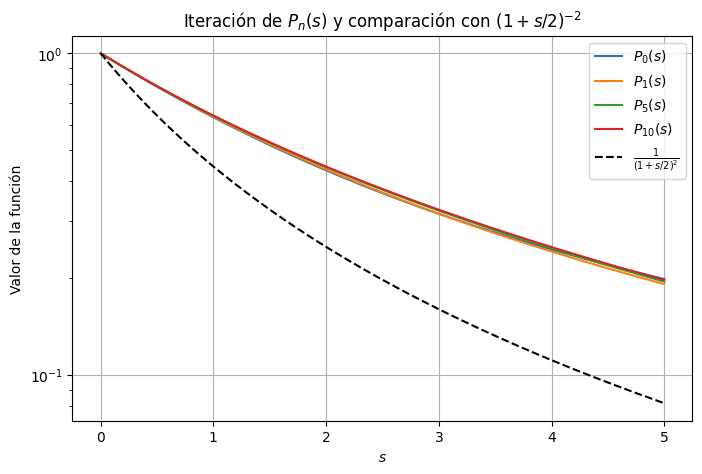

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_sequence(P0, s_max, N, n_points=2001, dtype=np.longdouble):
    """
    Computa la secuencia P_n(s) = [(1/s) ∫_0^s P_{n-1}(u) du]^2
    usando regla trapezoidal sobre una malla que INCLUYE s = 0.

    Parámetros:
    - P0: función Python que acepta floats y devuelve floats
    - s_max: valor máximo de s para la malla en [0, s_max]
    - N: número de iteraciones
    - n_points: número de puntos en la malla (incluye 0 y s_max)
    - dtype: tipo numpy para mayor precisión (float64 o longdouble)

    Retorna:
    - s_vals: array de puntos de s de longitud n_points
    - seq: lista de arrays [P0(s_vals), P1(s_vals), …, P_N(s_vals)]
    """
    s_vals = np.linspace(0, s_max, n_points, dtype=dtype)
    # Evaluar P0 en todos los puntos (incluido s=0)
    P_prev = np.array([P0(s) for s in s_vals], dtype=dtype)
    seq = [P_prev.copy()]
    integrals = np.zeros_like(s_vals, dtype=dtype)

    for n in range(1, N+1):
        integrals[0] = 0
        for i in range(1, len(s_vals)):
            ds = s_vals[i] - s_vals[i-1]
            integrals[i] = integrals[i-1] + 0.5 * (P_prev[i-1] + P_prev[i]) * ds
        Pn = np.empty_like(s_vals, dtype=dtype)
        # Límite en s=0:
        Pn[0] = P_prev[0]**2
        # Para s>0:
        Pn[1:] = (integrals[1:] / s_vals[1:])**2
        seq.append(Pn.copy())
        P_prev = Pn

    return s_vals, seq

if __name__ == "__main__":
    # Parámetros
    s_max    = 5             # valor máximo de s
    N        = 10            # número de iteraciones
    n_points = 2001          # puntos en la malla (incluye 0)
    dtype    = np.longdouble # usar longdouble para más precisión

    # Función inicial P0(s) = (1 - e^{-s})/s, con valor 1 en s=0
    def P0(s):
        return (1.0 - np.exp(-s)) / s if s != 0 else 1.0

    # Calculamos la secuencia P_n(s)
    s_vals, seq = compute_sequence(P0, s_max, N, n_points, dtype)

    # Definimos g(s) = 1/(1 + s/2)^2
    g_vals = 1.0 / (1.0 + s_vals/2.0)**2

    # Graficamos P0, P1, P5, P10 y g(s)
    plt.figure(figsize=(8, 5))
    for idx in [0, 1, 5, 10]:
        plt.plot(s_vals, seq[idx], label=f'$P_{{{idx}}}(s)$')
    plt.plot(s_vals, g_vals, 'k--', label=r'$\frac{1}{(1 + s/2)^2}$')
    plt.yscale('log')
    plt.xlabel('$s$')
    plt.ylabel('Valor de la función')
    plt.title('Iteración de $P_n(s)$ y comparación con $(1 + s/2)^{-2}$')
    plt.legend()
    plt.grid(True)
    plt.show()


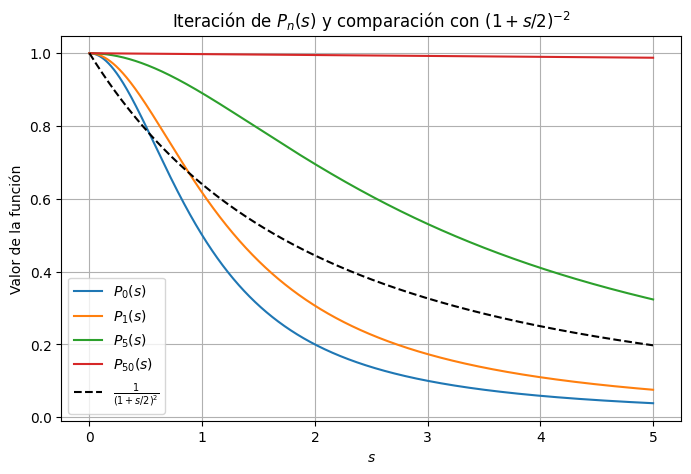

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def compute_sequence(P0, s_max, N, n_points=2001, dtype=np.longdouble):
    """
    Computa la secuencia P_n(s) = [(1/s) ∫_0^s P_{n-1}(u) du]^2
    usando regla trapezoidal sobre una malla que INCLUYE s = 0.

    Parámetros:
    - P0: función Python que acepta floats y devuelve floats
    - s_max: valor máximo de s para la malla en [0, s_max]
    - N: número de iteraciones
    - n_points: número de puntos en la malla (incluye 0 y s_max)
    - dtype: tipo numpy para mayor precisión (float64 o longdouble)

    Retorna:
    - s_vals: array de puntos de s de longitud n_points
    - seq: lista de arrays [P0(s_vals), P1(s_vals), …, P_N(s_vals)]
    """
    s_vals = np.linspace(0, s_max, n_points, dtype=dtype)
    # Evaluar P0 en todos los puntos (incluido s=0)
    P_prev = np.array([P0(s) for s in s_vals], dtype=dtype)
    seq = [P_prev.copy()]
    integrals = np.zeros_like(s_vals, dtype=dtype)

    for n in range(1, N+1):
        integrals[0] = 0
        for i in range(1, len(s_vals)):
            ds = s_vals[i] - s_vals[i-1]
            integrals[i] = integrals[i-1] + 0.5 * (P_prev[i-1] + P_prev[i]) * ds
        Pn = np.empty_like(s_vals, dtype=dtype)
        # Límite en s=0:
        Pn[0] = P_prev[0]**2
        # Para s>0:
        Pn[1:] = (integrals[1:] / s_vals[1:])**2
        seq.append(Pn.copy())
        P_prev = Pn

    return s_vals, seq

if __name__ == "__main__":
    # Parámetros
    s_max    = 5             # valor máximo de s
    N        = 50            # número de iteraciones
    n_points = 2001          # puntos en la malla (incluye 0)
    dtype    = np.longdouble # usar longdouble para más precisión

    # Función inicial P0(s) = (1 - e^{-s})/s, con valor 1 en s=0
    def P0(s):
        #return (1.0 - np.exp(-s)) / s if s != 0 else 1.0
        return 1.0/(1+s*s)

    # Calculamos la secuencia P_n(s)
    s_vals, seq = compute_sequence(P0, s_max, N, n_points, dtype)

    # Definimos g(s) = 1/(1 + s/2)^2
    g_vals = 1.0 / (1.0 + s_vals/4)**2

    # Graficamos P0, P1, P5, P10 y g(s)
    plt.figure(figsize=(8, 5))
    for idx in [0, 1, 5, 50]:
        plt.plot(s_vals, seq[idx], label=f'$P_{{{idx}}}(s)$')
    plt.plot(s_vals, g_vals, 'k--', label=r'$\frac{1}{(1 + s/2)^2}$')

    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('$s$')
    plt.ylabel('Valor de la función')
    plt.title('Iteración de $P_n(s)$ y comparación con $(1 + s/2)^{-2}$')
    plt.legend()
    plt.grid(True)
    plt.show()


In [1]:
import numpy as np

def multiplicar_vector_por_matrices(n):
    # Genera un vector 2D con entradas ~ U(0,1)
    v = np.random.rand(2)
    print(f"Vector inicial: {v}")

    # Repite n veces:
    for i in range(1, n+1):
        # Genera una matriz 2×2 con entradas ~ U(0,1)
        M = np.random.rand(2, 2)
        # Multiplica la matriz por el vector
        v = M @ v
        #print(f"Después de multiplicación {i}: {v}")

    # Vector resultante final
    print(f"\nVector resultante tras {n} multiplicaciones: {v}")
    return v


n=1000    
multiplicar_vector_por_matrices(n)


Vector inicial: [0.74728597 0.84499637]

Vector resultante tras 1000 multiplicaciones: [3.0606038e-19 9.2631352e-20]


array([3.0606038e-19, 9.2631352e-20])

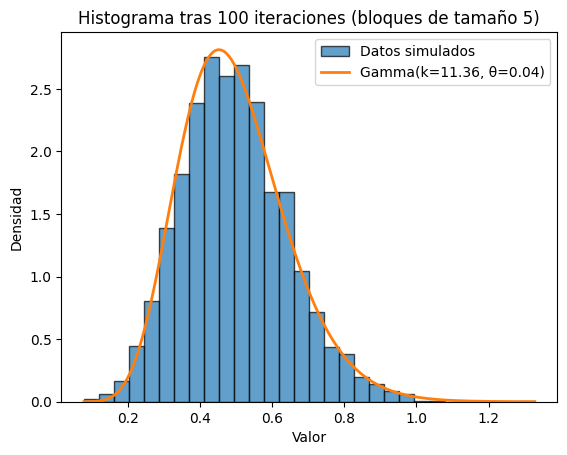

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

def simulate(N, M):
    """
    Simula un vector de longitud M*1000 iterativamente:
    - Se divide el vector en 1000 bloques de tamaño M.
    - Cada bloque se multiplica por una matriz W de tamaño MxM
      con filas normalizadas.
    - Tras actualizar todos los bloques, se aplica un random shuffle.
    - Repetir N veces y mostrar el histograma final.
    """
    # Vector inicial de M*1000 componentes ~ U(0,1)
    v = np.random.rand(M * 1000)

    for iteration in range(1, N + 1):
        new_v = np.empty_like(v)
        # Número de bloques
        num_blocks = len(v) // M
        
        for b in range(num_blocks):
            # Generar matriz MxM aleatoria
            W = np.random.rand(M, M)
            # Normalizar filas de W (para que cada fila sume 1)
            row_sums = W.sum(axis=0, keepdims=True)
            W = W / row_sums
            
            # Extraer bloque y multiplicar
            start = b * M
            end = start + M
            block = v[start:end]
            new_v[start:end] = W @ block
        
        # Desordenar componentes
        np.random.shuffle(new_v)
        v = new_v

    # Cálculo de media y varianza muestrales
    mu = v.mean()
    var = v.var(ddof=1)  # ddof=1 para varianza muestral

    # Parámetros de la gamma: 
    #   forma (k) = mu^2 / var
    #   escala (theta) = var / mu
    k = mu**2 / var
    theta = var / mu

    # Dibujar histograma
    count, bins, _ = plt.hist(v, bins=30, density=True,
                              edgecolor='black', alpha=0.7,
                              label='Datos simulados')

    # Puntos para la PDF teórica
    x = np.linspace(bins[0], bins[-1], 200)
    pdf = gamma.pdf(x, a=k, scale=theta)

    # Sobreponer la curva gamma
    plt.plot(x, pdf, linewidth=2, label=f'Gamma(k={k:.2f}, θ={theta:.2f})')

    # Etiquetas y leyenda
    plt.title(f"Histograma tras {N} iteraciones (bloques de tamaño {M})")
    plt.xlabel("Valor")
    plt.ylabel("Densidad")
    plt.legend()
    plt.show()

# Ejemplo de uso:
if __name__ == "__main__":
    N = 100   # Número de iteraciones
    M = 5     # Tamaño de cada bloque y de W
    simulate(N, M)
